# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [15]:
# Load pickled data
import pickle
import pandas as pd 

backup = pd.HDFStore('backup.h5')
# TODO: Fill this in based on where you saved the training and testing data

training_file ='./traffic-signs-data/train.p' 
validation_file='./traffic-signs-data/valid.p'
testing_file = './traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [16]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np

assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

# TODO: Number of training examples
n_train = len(y_train)

# TODO: Number of validation examples
n_validation = len(y_valid)

# TODO: Number of testing examples.
n_test = len(y_test)

# TODO: What's the shape of an traffic sign image?
image_shape = np.array(X_test).shape[1:4]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(np.array(y_test))[-1] + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [17]:
###functions for image augmentation 

import cv2
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import glob

def transform_image(img,ang_range,shear_range,trans_range):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
    
    i = 0
    for batch in datagen.flow(np.array([img]), batch_size=1,
                          save_to_dir='generated', save_prefix='signs', save_format='jpeg'):
        return batch
    
    return img

def equalize_hist(img):
    img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    
    # equalize the histogram of the Y channel only
    img_yuv[:,:,0] = cv2.equalizeHist(np.array(img_yuv[:,:,0]).astype(np.uint8))
    
    #apply contrast limited adaptive histogram equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_yuv[:,:,0] = clahe.apply(img_yuv[:,:,0])
    img_yuv = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
    return img_yuv


def create_extra_data (full_x, full_y, start_index ,data_slice, data_class, extra_data_limit): 
    old_size = len(data_slice)
    size = old_size
    index = 0 
    while size < extra_data_limit: 
        transformed_img = transform_image(np.copy(data_slice[index]), 30,10,10)
        full_x = np.append(transformed_img, full_x, axis=0 )
        full_y = np.append(np.array(np.copy([data_class])), full_y, axis=0)
        size += 1
        index = (index + 1)%old_size
        
    return full_x, full_y

def process_dataset(data_x, data_y, freq, indices, u,  extra_data_limit=800):
    old_size = len(data_y)
    print("Augmenting training data...")
    mask = freq < extra_data_limit
    
    freq = freq[mask]
    indices = indices[mask]
    u = u[mask]
    
    for i in range(len(indices)): 
        print(freq[i])
        data_slice = np.array(data_x[indices[i]:indices[i]+ freq[i]])
        data_x, data_y = create_extra_data(data_x , data_y , indices[i], data_slice, u[i], extra_data_limit) 
    
    print(len(data_y))
    return data_x, data_y, len(data_y)

def load_extra_data(X_data, y_data):
    print("Loading generated data...")
    for filename in os.listdir('generated'):
        img = cv2.imread(os.path.join('generated',filename))
        if img is not None:
            print(filename)
            data_class = int(filename.split('_', 2)[1])
            X_data = np.append(np.array([img]),X_data, axis=0)
            y_data = np.append(np.array([data_class]), y_data, axis=0)
    print('All image successfully loaded!')
    
    return X_data, y_data, len(y_data)

def equalize_data(data): 
    print("Equalizing...")
    for i in range(len(data)):
        print(i)
        data[i] = equalize_hist(np.array(data[i]))
        
    return data

In [18]:
### Data processing/augmentation
import random 
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from math import ceil
import os
# Visualizations will be shown in the notebook.
%matplotlib inline

#histogram equalization on all data
X_train = equalize_data(X_train)
X_valid = equalize_data(X_valid)
X_test = equalize_data(X_test)        



#sort training set after data equlization for visualization
sorted_indices = np.argsort(y_test)
y_test = y_test[sorted_indices]
X_test = X_test[sorted_indices]
u, indices, freq = np.unique(y_test, return_index=True, return_counts=True)
sorted_indices = np.argsort(u)
u = u[sorted_indices]
indices = indices[sorted_indices]
freq = freq[sorted_indices]


Equalizing...
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273


1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118


4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195
4196
4197
4198
4199
4200
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219
4220
4221
4222
4223
4224
4225
4226
4227
4228
4229
4230
4231
4232
4233
4234
4235
4236
4237
4238
4239
4240
4241
4242
4243
4244
4245
4246
4247
4248
4249
4250
4251
4252
4253
4254
4255
4256
4257
4258
4259
4260
4261
4262
4263
4264
4265
4266
4267
4268
4269
4270
4271
4272
4273
4274
4275
4276
4277
4278
4279
4280
4281
4282
4283
4284
4285
4286
4287
4288
4289
4290
4291
4292


6268
6269
6270
6271
6272
6273
6274
6275
6276
6277
6278
6279
6280
6281
6282
6283
6284
6285
6286
6287
6288
6289
6290
6291
6292
6293
6294
6295
6296
6297
6298
6299
6300
6301
6302
6303
6304
6305
6306
6307
6308
6309
6310
6311
6312
6313
6314
6315
6316
6317
6318
6319
6320
6321
6322
6323
6324
6325
6326
6327
6328
6329
6330
6331
6332
6333
6334
6335
6336
6337
6338
6339
6340
6341
6342
6343
6344
6345
6346
6347
6348
6349
6350
6351
6352
6353
6354
6355
6356
6357
6358
6359
6360
6361
6362
6363
6364
6365
6366
6367
6368
6369
6370
6371
6372
6373
6374
6375
6376
6377
6378
6379
6380
6381
6382
6383
6384
6385
6386
6387
6388
6389
6390
6391
6392
6393
6394
6395
6396
6397
6398
6399
6400
6401
6402
6403
6404
6405
6406
6407
6408
6409
6410
6411
6412
6413
6414
6415
6416
6417
6418
6419
6420
6421
6422
6423
6424
6425
6426
6427
6428
6429
6430
6431
6432
6433
6434
6435
6436
6437
6438
6439
6440
6441
6442
6443
6444
6445
6446
6447
6448
6449
6450
6451
6452
6453
6454
6455
6456
6457
6458
6459
6460
6461
6462
6463
6464
6465
6466
6467


8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643


10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
10229
10230
10231
10232
10233
10234
10235
10236
10237
10238
10239
10240
10241
10242
10243
10244
1024

11663
11664
11665
11666
11667
11668
11669
11670
11671
11672
11673
11674
11675
11676
11677
11678
11679
11680
11681
11682
11683
11684
11685
11686
11687
11688
11689
11690
11691
11692
11693
11694
11695
11696
11697
11698
11699
11700
11701
11702
11703
11704
11705
11706
11707
11708
11709
11710
11711
11712
11713
11714
11715
11716
11717
11718
11719
11720
11721
11722
11723
11724
11725
11726
11727
11728
11729
11730
11731
11732
11733
11734
11735
11736
11737
11738
11739
11740
11741
11742
11743
11744
11745
11746
11747
11748
11749
11750
11751
11752
11753
11754
11755
11756
11757
11758
11759
11760
11761
11762
11763
11764
11765
11766
11767
11768
11769
11770
11771
11772
11773
11774
11775
11776
11777
11778
11779
11780
11781
11782
11783
11784
11785
11786
11787
11788
11789
11790
11791
11792
11793
11794
11795
11796
11797
11798
11799
11800
11801
11802
11803
11804
11805
11806
11807
11808
11809
11810
11811
11812
11813
11814
11815
11816
11817
11818
11819
11820
11821
11822
11823
11824
11825
11826
11827
11828
1182

13291
13292
13293
13294
13295
13296
13297
13298
13299
13300
13301
13302
13303
13304
13305
13306
13307
13308
13309
13310
13311
13312
13313
13314
13315
13316
13317
13318
13319
13320
13321
13322
13323
13324
13325
13326
13327
13328
13329
13330
13331
13332
13333
13334
13335
13336
13337
13338
13339
13340
13341
13342
13343
13344
13345
13346
13347
13348
13349
13350
13351
13352
13353
13354
13355
13356
13357
13358
13359
13360
13361
13362
13363
13364
13365
13366
13367
13368
13369
13370
13371
13372
13373
13374
13375
13376
13377
13378
13379
13380
13381
13382
13383
13384
13385
13386
13387
13388
13389
13390
13391
13392
13393
13394
13395
13396
13397
13398
13399
13400
13401
13402
13403
13404
13405
13406
13407
13408
13409
13410
13411
13412
13413
13414
13415
13416
13417
13418
13419
13420
13421
13422
13423
13424
13425
13426
13427
13428
13429
13430
13431
13432
13433
13434
13435
13436
13437
13438
13439
13440
13441
13442
13443
13444
13445
13446
13447
13448
13449
13450
13451
13452
13453
13454
13455
13456
1345

14922
14923
14924
14925
14926
14927
14928
14929
14930
14931
14932
14933
14934
14935
14936
14937
14938
14939
14940
14941
14942
14943
14944
14945
14946
14947
14948
14949
14950
14951
14952
14953
14954
14955
14956
14957
14958
14959
14960
14961
14962
14963
14964
14965
14966
14967
14968
14969
14970
14971
14972
14973
14974
14975
14976
14977
14978
14979
14980
14981
14982
14983
14984
14985
14986
14987
14988
14989
14990
14991
14992
14993
14994
14995
14996
14997
14998
14999
15000
15001
15002
15003
15004
15005
15006
15007
15008
15009
15010
15011
15012
15013
15014
15015
15016
15017
15018
15019
15020
15021
15022
15023
15024
15025
15026
15027
15028
15029
15030
15031
15032
15033
15034
15035
15036
15037
15038
15039
15040
15041
15042
15043
15044
15045
15046
15047
15048
15049
15050
15051
15052
15053
15054
15055
15056
15057
15058
15059
15060
15061
15062
15063
15064
15065
15066
15067
15068
15069
15070
15071
15072
15073
15074
15075
15076
15077
15078
15079
15080
15081
15082
15083
15084
15085
15086
15087
1508

16552
16553
16554
16555
16556
16557
16558
16559
16560
16561
16562
16563
16564
16565
16566
16567
16568
16569
16570
16571
16572
16573
16574
16575
16576
16577
16578
16579
16580
16581
16582
16583
16584
16585
16586
16587
16588
16589
16590
16591
16592
16593
16594
16595
16596
16597
16598
16599
16600
16601
16602
16603
16604
16605
16606
16607
16608
16609
16610
16611
16612
16613
16614
16615
16616
16617
16618
16619
16620
16621
16622
16623
16624
16625
16626
16627
16628
16629
16630
16631
16632
16633
16634
16635
16636
16637
16638
16639
16640
16641
16642
16643
16644
16645
16646
16647
16648
16649
16650
16651
16652
16653
16654
16655
16656
16657
16658
16659
16660
16661
16662
16663
16664
16665
16666
16667
16668
16669
16670
16671
16672
16673
16674
16675
16676
16677
16678
16679
16680
16681
16682
16683
16684
16685
16686
16687
16688
16689
16690
16691
16692
16693
16694
16695
16696
16697
16698
16699
16700
16701
16702
16703
16704
16705
16706
16707
16708
16709
16710
16711
16712
16713
16714
16715
16716
16717
1671

18182
18183
18184
18185
18186
18187
18188
18189
18190
18191
18192
18193
18194
18195
18196
18197
18198
18199
18200
18201
18202
18203
18204
18205
18206
18207
18208
18209
18210
18211
18212
18213
18214
18215
18216
18217
18218
18219
18220
18221
18222
18223
18224
18225
18226
18227
18228
18229
18230
18231
18232
18233
18234
18235
18236
18237
18238
18239
18240
18241
18242
18243
18244
18245
18246
18247
18248
18249
18250
18251
18252
18253
18254
18255
18256
18257
18258
18259
18260
18261
18262
18263
18264
18265
18266
18267
18268
18269
18270
18271
18272
18273
18274
18275
18276
18277
18278
18279
18280
18281
18282
18283
18284
18285
18286
18287
18288
18289
18290
18291
18292
18293
18294
18295
18296
18297
18298
18299
18300
18301
18302
18303
18304
18305
18306
18307
18308
18309
18310
18311
18312
18313
18314
18315
18316
18317
18318
18319
18320
18321
18322
18323
18324
18325
18326
18327
18328
18329
18330
18331
18332
18333
18334
18335
18336
18337
18338
18339
18340
18341
18342
18343
18344
18345
18346
18347
1834

19813
19814
19815
19816
19817
19818
19819
19820
19821
19822
19823
19824
19825
19826
19827
19828
19829
19830
19831
19832
19833
19834
19835
19836
19837
19838
19839
19840
19841
19842
19843
19844
19845
19846
19847
19848
19849
19850
19851
19852
19853
19854
19855
19856
19857
19858
19859
19860
19861
19862
19863
19864
19865
19866
19867
19868
19869
19870
19871
19872
19873
19874
19875
19876
19877
19878
19879
19880
19881
19882
19883
19884
19885
19886
19887
19888
19889
19890
19891
19892
19893
19894
19895
19896
19897
19898
19899
19900
19901
19902
19903
19904
19905
19906
19907
19908
19909
19910
19911
19912
19913
19914
19915
19916
19917
19918
19919
19920
19921
19922
19923
19924
19925
19926
19927
19928
19929
19930
19931
19932
19933
19934
19935
19936
19937
19938
19939
19940
19941
19942
19943
19944
19945
19946
19947
19948
19949
19950
19951
19952
19953
19954
19955
19956
19957
19958
19959
19960
19961
19962
19963
19964
19965
19966
19967
19968
19969
19970
19971
19972
19973
19974
19975
19976
19977
19978
1997

21441
21442
21443
21444
21445
21446
21447
21448
21449
21450
21451
21452
21453
21454
21455
21456
21457
21458
21459
21460
21461
21462
21463
21464
21465
21466
21467
21468
21469
21470
21471
21472
21473
21474
21475
21476
21477
21478
21479
21480
21481
21482
21483
21484
21485
21486
21487
21488
21489
21490
21491
21492
21493
21494
21495
21496
21497
21498
21499
21500
21501
21502
21503
21504
21505
21506
21507
21508
21509
21510
21511
21512
21513
21514
21515
21516
21517
21518
21519
21520
21521
21522
21523
21524
21525
21526
21527
21528
21529
21530
21531
21532
21533
21534
21535
21536
21537
21538
21539
21540
21541
21542
21543
21544
21545
21546
21547
21548
21549
21550
21551
21552
21553
21554
21555
21556
21557
21558
21559
21560
21561
21562
21563
21564
21565
21566
21567
21568
21569
21570
21571
21572
21573
21574
21575
21576
21577
21578
21579
21580
21581
21582
21583
21584
21585
21586
21587
21588
21589
21590
21591
21592
21593
21594
21595
21596
21597
21598
21599
21600
21601
21602
21603
21604
21605
21606
2160

23073
23074
23075
23076
23077
23078
23079
23080
23081
23082
23083
23084
23085
23086
23087
23088
23089
23090
23091
23092
23093
23094
23095
23096
23097
23098
23099
23100
23101
23102
23103
23104
23105
23106
23107
23108
23109
23110
23111
23112
23113
23114
23115
23116
23117
23118
23119
23120
23121
23122
23123
23124
23125
23126
23127
23128
23129
23130
23131
23132
23133
23134
23135
23136
23137
23138
23139
23140
23141
23142
23143
23144
23145
23146
23147
23148
23149
23150
23151
23152
23153
23154
23155
23156
23157
23158
23159
23160
23161
23162
23163
23164
23165
23166
23167
23168
23169
23170
23171
23172
23173
23174
23175
23176
23177
23178
23179
23180
23181
23182
23183
23184
23185
23186
23187
23188
23189
23190
23191
23192
23193
23194
23195
23196
23197
23198
23199
23200
23201
23202
23203
23204
23205
23206
23207
23208
23209
23210
23211
23212
23213
23214
23215
23216
23217
23218
23219
23220
23221
23222
23223
23224
23225
23226
23227
23228
23229
23230
23231
23232
23233
23234
23235
23236
23237
23238
2323

24702
24703
24704
24705
24706
24707
24708
24709
24710
24711
24712
24713
24714
24715
24716
24717
24718
24719
24720
24721
24722
24723
24724
24725
24726
24727
24728
24729
24730
24731
24732
24733
24734
24735
24736
24737
24738
24739
24740
24741
24742
24743
24744
24745
24746
24747
24748
24749
24750
24751
24752
24753
24754
24755
24756
24757
24758
24759
24760
24761
24762
24763
24764
24765
24766
24767
24768
24769
24770
24771
24772
24773
24774
24775
24776
24777
24778
24779
24780
24781
24782
24783
24784
24785
24786
24787
24788
24789
24790
24791
24792
24793
24794
24795
24796
24797
24798
24799
24800
24801
24802
24803
24804
24805
24806
24807
24808
24809
24810
24811
24812
24813
24814
24815
24816
24817
24818
24819
24820
24821
24822
24823
24824
24825
24826
24827
24828
24829
24830
24831
24832
24833
24834
24835
24836
24837
24838
24839
24840
24841
24842
24843
24844
24845
24846
24847
24848
24849
24850
24851
24852
24853
24854
24855
24856
24857
24858
24859
24860
24861
24862
24863
24864
24865
24866
24867
2486

26332
26333
26334
26335
26336
26337
26338
26339
26340
26341
26342
26343
26344
26345
26346
26347
26348
26349
26350
26351
26352
26353
26354
26355
26356
26357
26358
26359
26360
26361
26362
26363
26364
26365
26366
26367
26368
26369
26370
26371
26372
26373
26374
26375
26376
26377
26378
26379
26380
26381
26382
26383
26384
26385
26386
26387
26388
26389
26390
26391
26392
26393
26394
26395
26396
26397
26398
26399
26400
26401
26402
26403
26404
26405
26406
26407
26408
26409
26410
26411
26412
26413
26414
26415
26416
26417
26418
26419
26420
26421
26422
26423
26424
26425
26426
26427
26428
26429
26430
26431
26432
26433
26434
26435
26436
26437
26438
26439
26440
26441
26442
26443
26444
26445
26446
26447
26448
26449
26450
26451
26452
26453
26454
26455
26456
26457
26458
26459
26460
26461
26462
26463
26464
26465
26466
26467
26468
26469
26470
26471
26472
26473
26474
26475
26476
26477
26478
26479
26480
26481
26482
26483
26484
26485
26486
26487
26488
26489
26490
26491
26492
26493
26494
26495
26496
26497
2649

27960
27961
27962
27963
27964
27965
27966
27967
27968
27969
27970
27971
27972
27973
27974
27975
27976
27977
27978
27979
27980
27981
27982
27983
27984
27985
27986
27987
27988
27989
27990
27991
27992
27993
27994
27995
27996
27997
27998
27999
28000
28001
28002
28003
28004
28005
28006
28007
28008
28009
28010
28011
28012
28013
28014
28015
28016
28017
28018
28019
28020
28021
28022
28023
28024
28025
28026
28027
28028
28029
28030
28031
28032
28033
28034
28035
28036
28037
28038
28039
28040
28041
28042
28043
28044
28045
28046
28047
28048
28049
28050
28051
28052
28053
28054
28055
28056
28057
28058
28059
28060
28061
28062
28063
28064
28065
28066
28067
28068
28069
28070
28071
28072
28073
28074
28075
28076
28077
28078
28079
28080
28081
28082
28083
28084
28085
28086
28087
28088
28089
28090
28091
28092
28093
28094
28095
28096
28097
28098
28099
28100
28101
28102
28103
28104
28105
28106
28107
28108
28109
28110
28111
28112
28113
28114
28115
28116
28117
28118
28119
28120
28121
28122
28123
28124
28125
2812

29600
29601
29602
29603
29604
29605
29606
29607
29608
29609
29610
29611
29612
29613
29614
29615
29616
29617
29618
29619
29620
29621
29622
29623
29624
29625
29626
29627
29628
29629
29630
29631
29632
29633
29634
29635
29636
29637
29638
29639
29640
29641
29642
29643
29644
29645
29646
29647
29648
29649
29650
29651
29652
29653
29654
29655
29656
29657
29658
29659
29660
29661
29662
29663
29664
29665
29666
29667
29668
29669
29670
29671
29672
29673
29674
29675
29676
29677
29678
29679
29680
29681
29682
29683
29684
29685
29686
29687
29688
29689
29690
29691
29692
29693
29694
29695
29696
29697
29698
29699
29700
29701
29702
29703
29704
29705
29706
29707
29708
29709
29710
29711
29712
29713
29714
29715
29716
29717
29718
29719
29720
29721
29722
29723
29724
29725
29726
29727
29728
29729
29730
29731
29732
29733
29734
29735
29736
29737
29738
29739
29740
29741
29742
29743
29744
29745
29746
29747
29748
29749
29750
29751
29752
29753
29754
29755
29756
29757
29758
29759
29760
29761
29762
29763
29764
29765
2976

31230
31231
31232
31233
31234
31235
31236
31237
31238
31239
31240
31241
31242
31243
31244
31245
31246
31247
31248
31249
31250
31251
31252
31253
31254
31255
31256
31257
31258
31259
31260
31261
31262
31263
31264
31265
31266
31267
31268
31269
31270
31271
31272
31273
31274
31275
31276
31277
31278
31279
31280
31281
31282
31283
31284
31285
31286
31287
31288
31289
31290
31291
31292
31293
31294
31295
31296
31297
31298
31299
31300
31301
31302
31303
31304
31305
31306
31307
31308
31309
31310
31311
31312
31313
31314
31315
31316
31317
31318
31319
31320
31321
31322
31323
31324
31325
31326
31327
31328
31329
31330
31331
31332
31333
31334
31335
31336
31337
31338
31339
31340
31341
31342
31343
31344
31345
31346
31347
31348
31349
31350
31351
31352
31353
31354
31355
31356
31357
31358
31359
31360
31361
31362
31363
31364
31365
31366
31367
31368
31369
31370
31371
31372
31373
31374
31375
31376
31377
31378
31379
31380
31381
31382
31383
31384
31385
31386
31387
31388
31389
31390
31391
31392
31393
31394
31395
3139

32859
32860
32861
32862
32863
32864
32865
32866
32867
32868
32869
32870
32871
32872
32873
32874
32875
32876
32877
32878
32879
32880
32881
32882
32883
32884
32885
32886
32887
32888
32889
32890
32891
32892
32893
32894
32895
32896
32897
32898
32899
32900
32901
32902
32903
32904
32905
32906
32907
32908
32909
32910
32911
32912
32913
32914
32915
32916
32917
32918
32919
32920
32921
32922
32923
32924
32925
32926
32927
32928
32929
32930
32931
32932
32933
32934
32935
32936
32937
32938
32939
32940
32941
32942
32943
32944
32945
32946
32947
32948
32949
32950
32951
32952
32953
32954
32955
32956
32957
32958
32959
32960
32961
32962
32963
32964
32965
32966
32967
32968
32969
32970
32971
32972
32973
32974
32975
32976
32977
32978
32979
32980
32981
32982
32983
32984
32985
32986
32987
32988
32989
32990
32991
32992
32993
32994
32995
32996
32997
32998
32999
33000
33001
33002
33003
33004
33005
33006
33007
33008
33009
33010
33011
33012
33013
33014
33015
33016
33017
33018
33019
33020
33021
33022
33023
33024
3302

34491
34492
34493
34494
34495
34496
34497
34498
34499
34500
34501
34502
34503
34504
34505
34506
34507
34508
34509
34510
34511
34512
34513
34514
34515
34516
34517
34518
34519
34520
34521
34522
34523
34524
34525
34526
34527
34528
34529
34530
34531
34532
34533
34534
34535
34536
34537
34538
34539
34540
34541
34542
34543
34544
34545
34546
34547
34548
34549
34550
34551
34552
34553
34554
34555
34556
34557
34558
34559
34560
34561
34562
34563
34564
34565
34566
34567
34568
34569
34570
34571
34572
34573
34574
34575
34576
34577
34578
34579
34580
34581
34582
34583
34584
34585
34586
34587
34588
34589
34590
34591
34592
34593
34594
34595
34596
34597
34598
34599
34600
34601
34602
34603
34604
34605
34606
34607
34608
34609
34610
34611
34612
34613
34614
34615
34616
34617
34618
34619
34620
34621
34622
34623
34624
34625
34626
34627
34628
34629
34630
34631
34632
34633
34634
34635
34636
34637
34638
34639
34640
34641
34642
34643
34644
34645
34646
34647
34648
34649
34650
34651
34652
34653
34654
34655
34656
3465

1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064


4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183
4184
4185
4186
4187
4188
4189
4190
4191
4192
4193
4194
4195
4196
4197
4198
4199
4200
4201
4202
4203
4204
4205
4206
4207
4208
4209
4210
4211
4212
4213
4214
4215
4216
4217
4218
4219
4220
4221
4222
4223
4224
4225
4226
4227
4228
4229
4230
4231
4232
4233
4234
4235
4236
4237
4238
4239
4240
4241
4242
4243


1829
1830
1831
1832
1833
1834
1835
1836
1837
1838
1839
1840
1841
1842
1843
1844
1845
1846
1847
1848
1849
1850
1851
1852
1853
1854
1855
1856
1857
1858
1859
1860
1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028


3468
3469
3470
3471
3472
3473
3474
3475
3476
3477
3478
3479
3480
3481
3482
3483
3484
3485
3486
3487
3488
3489
3490
3491
3492
3493
3494
3495
3496
3497
3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667


5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314


6759
6760
6761
6762
6763
6764
6765
6766
6767
6768
6769
6770
6771
6772
6773
6774
6775
6776
6777
6778
6779
6780
6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958


8405
8406
8407
8408
8409
8410
8411
8412
8413
8414
8415
8416
8417
8418
8419
8420
8421
8422
8423
8424
8425
8426
8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604


10053
10054
10055
10056
10057
10058
10059
10060
10061
10062
10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
1021

11705
11706
11707
11708
11709
11710
11711
11712
11713
11714
11715
11716
11717
11718
11719
11720
11721
11722
11723
11724
11725
11726
11727
11728
11729
11730
11731
11732
11733
11734
11735
11736
11737
11738
11739
11740
11741
11742
11743
11744
11745
11746
11747
11748
11749
11750
11751
11752
11753
11754
11755
11756
11757
11758
11759
11760
11761
11762
11763
11764
11765
11766
11767
11768
11769
11770
11771
11772
11773
11774
11775
11776
11777
11778
11779
11780
11781
11782
11783
11784
11785
11786
11787
11788
11789
11790
11791
11792
11793
11794
11795
11796
11797
11798
11799
11800
11801
11802
11803
11804
11805
11806
11807
11808
11809
11810
11811
11812
11813
11814
11815
11816
11817
11818
11819
11820
11821
11822
11823
11824
11825
11826
11827
11828
11829
11830
11831
11832
11833
11834
11835
11836
11837
11838
11839
11840
11841
11842
11843
11844
11845
11846
11847
11848
11849
11850
11851
11852
11853
11854
11855
11856
11857
11858
11859
11860
11861
11862
11863
11864
11865
11866
11867
11868
11869
11870
1187

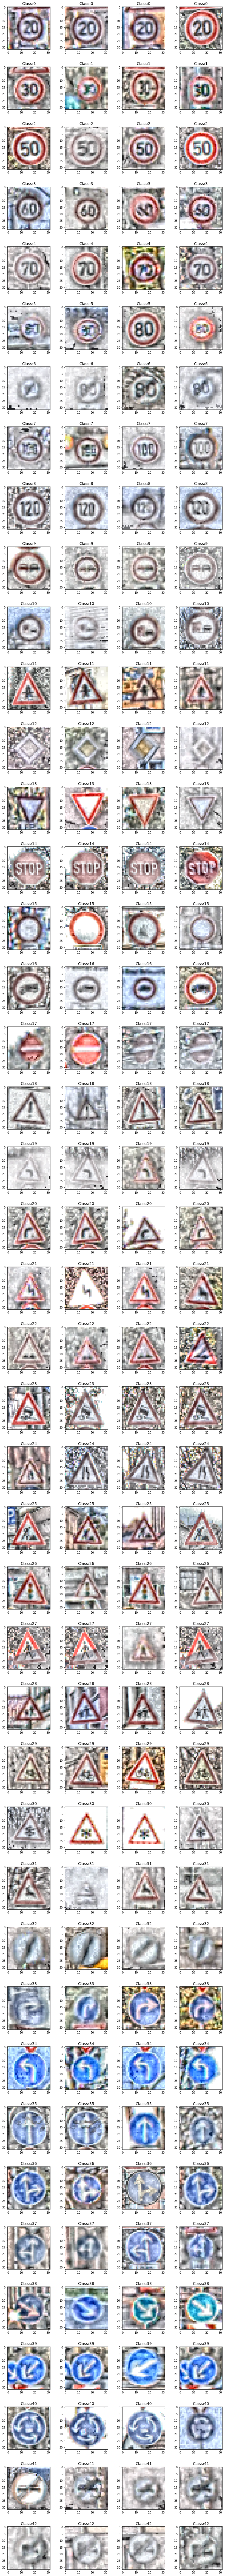

In [19]:
f, axarr = plt.subplots(n_classes, 4, figsize=(15,n_classes*4))
plt.figure()
f.subplots_adjust(hspace = .4, wspace=.001)
for i in range(0, len(indices)):    
    for j in range (4):
        randomIndex = np.random.randint(low=0, high=freq[i])
        subtitle = "Class:" + str(y_test[indices[i] + randomIndex])
        axarr[i,j].set_title(subtitle, fontsize=14)
        axarr[i,j].set_aspect(aspect=1, adjustable='box')
        axarr[i,j].imshow(np.round(X_test[indices[i] + randomIndex]).astype(np.uint8))


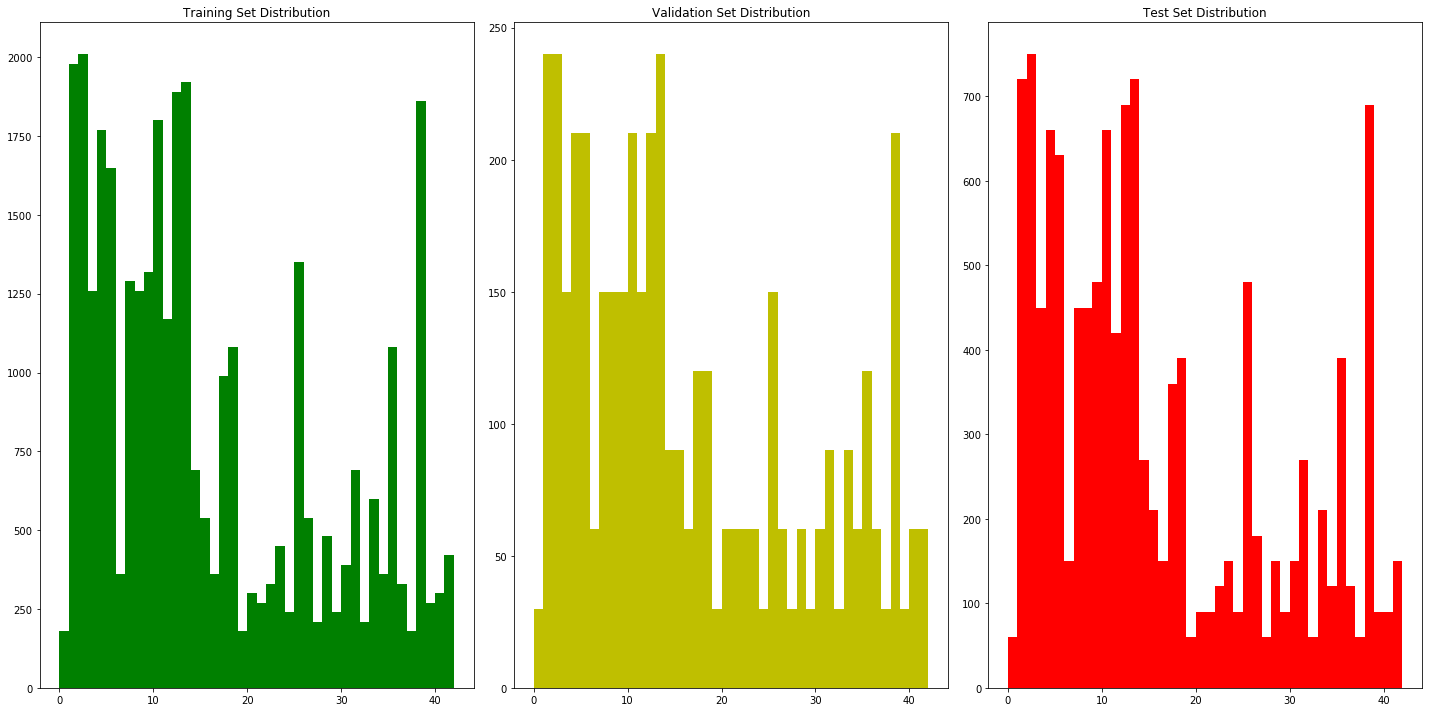

In [20]:

bins = range(n_classes) 

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(20, 10))

ax0.hist(y_train, bins,  histtype='stepfilled', facecolor='g')
ax0.set_title('Training Set Distribution')

# Create a histogram by providing the bin edges (unequally spaced).
ax1.hist(y_valid, bins, histtype='stepfilled', facecolor='y')
ax1.set_title('Validation Set Distribution')


# Create a histogram by providing the bin edges (unequally spaced).
ax2.hist(y_test, bins,  histtype='stepfilled', facecolor='r')
ax2.set_title('Test Set Distribution')

fig.tight_layout()
plt.show()
plt.close('all')


#leave the relative distributions of the signs the same -> biases the model to pick the sign with higher frequency 
#in the validation set at times of uncertainty


# ----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [21]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.
from sklearn.utils import shuffle
 
X_train, y_train = shuffle(X_train, y_train)

#normalizing data
X_train = ( X_train - np.mean(X_train) ) / np.std(X_train)
X_valid = ( X_valid - np.mean(X_valid) ) / np.std(X_valid)
X_test = ( X_test - np.mean(X_test) ) / np.std(X_test)

### Model Architecture

In [35]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf

EPOCHS = 60
BATCH_SIZE = 128
BETA = 0.01
from tensorflow.contrib.layers import flatten

keep_prob = tf.placeholder(tf.float32) 

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    factor = 3
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6*factor), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6*factor))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    tf.nn.dropout(conv1, keep_prob)
    
    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6*factor, 16*factor), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16*factor))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)
    
    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    tf.nn.dropout(conv2, keep_prob)
    
    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400*factor, 120*factor), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120*factor))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)
    

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120*factor, 84*factor), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84*factor))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)
    
    tf.nn.dropout(fc2, keep_prob)
    
    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84*factor, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    
    
    return logits

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, tf.cast(n_classes, tf.int32))


### Train, Validate and Test the Model

# A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [36]:
### Train your model here.
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)


### Calculate and report the accuracy on the training and validation set.
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1})
        total_accuracy += (accuracy * BATCH_SIZE)
    return total_accuracy / (num_examples)

### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            #if end < num_examples:
            #    batch_x, batch_y = create_train_batch(X_train[offset:end], y_train[offset:end],BATCH_SIZE, extra_data_per_element=4)
            #else: 
            #    batch_x, batch_y = create_train_batch(X_train[offset:end], y_train[offset:offset+BATCH_SIZE], num_examples - offset, extra_data_per_element=4)
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
        
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        if validation_accuracy > 0.99:
            break;
        
    saver.save(sess, './lenet')
    print("Model saved")



### Feel free to use as many code cells as needed.

Training...

EPOCH 1 ...
Validation Accuracy = 0.923

EPOCH 2 ...
Validation Accuracy = 0.941

EPOCH 3 ...
Validation Accuracy = 0.956

EPOCH 4 ...
Validation Accuracy = 0.952

EPOCH 5 ...
Validation Accuracy = 0.964

EPOCH 6 ...
Validation Accuracy = 0.967

EPOCH 7 ...
Validation Accuracy = 0.961

EPOCH 8 ...
Validation Accuracy = 0.970

EPOCH 9 ...
Validation Accuracy = 0.965

EPOCH 10 ...
Validation Accuracy = 0.968

EPOCH 11 ...
Validation Accuracy = 0.967

EPOCH 12 ...
Validation Accuracy = 0.968

EPOCH 13 ...
Validation Accuracy = 0.969

EPOCH 14 ...
Validation Accuracy = 0.974

EPOCH 15 ...
Validation Accuracy = 0.967

EPOCH 16 ...
Validation Accuracy = 0.975

EPOCH 17 ...
Validation Accuracy = 0.962

EPOCH 18 ...
Validation Accuracy = 0.980

EPOCH 19 ...
Validation Accuracy = 0.992

Model saved


In [88]:
#test our model on the test set 
with tf.Session() as sess: 
    saver.restore(sess, './lenet') 
    test_accuracy = evaluate(X_test, y_test)
    print("test Accuracy = {:.3f}".format(test_accuracy))
    print()


Validation Accuracy = 0.950



---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

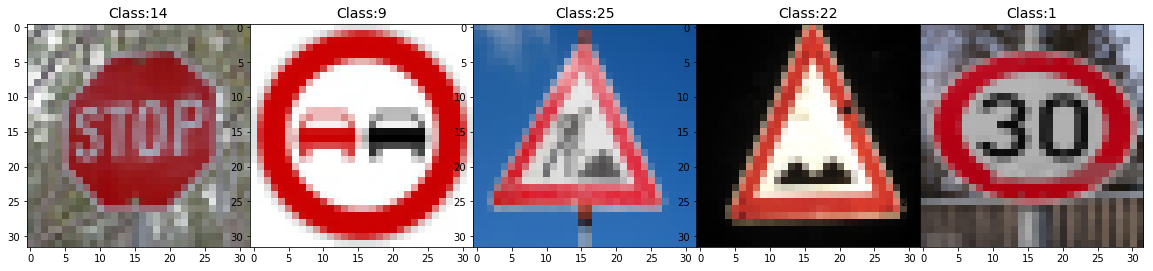

In [104]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import matplotlib.image as mpimg


stop_img = mpimg.imread('extra_signs/STOP_sign.jpg')
stop_img = cv2.resize(stop_img, (32, 32), interpolation = cv2.INTER_AREA)

no_passing_img = mpimg.imread('extra_signs/no_passing_sign.jpg')
no_passing_img = cv2.resize(no_passing_img, (32, 32), interpolation = cv2.INTER_AREA)

roadwork_img = mpimg.imread('extra_signs/road_work_sign.jpg')
roadwork_img = cv2.resize(roadwork_img, (32, 32), interpolation = cv2.INTER_AREA)

bumpy_img = mpimg.imread('extra_signs/bumpy_road_sign.jpg')
bumpy_img = cv2.resize(bumpy_img, (32, 32), interpolation = cv2.INTER_AREA) 

_30_img = mpimg.imread('extra_signs/30_sign.jpg')
_30_img = cv2.resize(_30_img, (32, 32), interpolation = cv2.INTER_AREA)  


test_images = np.array([stop_img, no_passing_img, roadwork_img, bumpy_img, _30_img])
classes = np.array([14, 9, 25, 22, 1])
num_images = 5

f, axarr = plt.subplots(1, num_images, figsize=(20,10))
plt.figure()
f.subplots_adjust(hspace = .4, wspace=.001)
for i in range(0, num_images):    
        subtitle = "Class:" + str(classes[i])
        axarr[i].set_title(subtitle, fontsize=14)
        axarr[i].set_aspect(aspect=1, adjustable='box')
        axarr[i].imshow(np.round(test_images[i]).astype(np.uint8))

### Predict the Sign Type for Each Image

In [105]:
def evaluate_web_images(X_data, y_data):
    num_examples = len(X_data)
    sess = tf.get_default_session()
    accuracy = sess.run(accuracy_operation, feed_dict={x: X_data, y: y_data, keep_prob:1})
    return accuracy

In [106]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed. 

#image preprocessing
test_images = equalize_data(test_images)
test_images = ( test_images - np.mean(test_images) ) / np.std(test_images)

#analyzing performance for images obtained from internet~
with tf.Session() as sess: 
    saver.restore(sess, './lenet') 
    web_accuracy = evaluate_web_images(test_images, classes)
    print("Random Test Accuracy = {:.3f}".format(web_accuracy))
    


Equalizing...
0
1
2
3
4
Random Test Accuracy = 1.000


### Analyze Performance

In [107]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [114]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
prob_num = tf.placeholder(tf.int32)
top_probablities = tf.nn.top_k(tf.nn.softmax(logits),prob_num)
with tf.Session() as sess: 
    saver.restore(sess, './lenet') 
    probablities = sess.run(top_probablities, feed_dict={x:test_images, y:classes, keep_prob:1, prob_num:5})
    print(probablities)
    

TopKV2(values=array([[  1.00000000e+00,   4.25229718e-09,   2.40412734e-09,
          1.16381793e-09,   1.11828535e-09],
       [  9.99999404e-01,   5.74804062e-07,   5.51254771e-11,
          2.47453035e-12,   5.08490494e-13],
       [  9.99776661e-01,   8.82334134e-05,   8.62602101e-05,
          3.38737009e-05,   6.81981828e-06],
       [  9.99999881e-01,   9.06253490e-08,   4.86541936e-08,
          9.83962956e-09,   1.90334526e-09],
       [  9.99918580e-01,   8.01061542e-05,   8.81266772e-07,
          1.82846421e-07,   1.78641628e-07]], dtype=float32), indices=array([[14,  0, 17, 25,  6],
       [ 9, 41, 12, 33, 23],
       [25,  5, 35, 14, 21],
       [22, 29, 26, 25,  8],
       [ 1, 13, 37,  5, 25]], dtype=int32))


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


# Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")